In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import time
import matplotlib.pyplot as plt

## Input Testing code:

In [ ]:
# cap =  cv2.VideoCapture(0, cv2.CAP_DSHOW)     # UNCOMMENT THIS LINE FOR WINDOWS
cap =  cv2.VideoCapture(0)                     # UNCOMMENT THIS LINE FOR LINUX

ref_img = False 

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if not ref_img:    
        cv2.imshow('Pressed Key Frame', frame_img)
        
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    cv2.waitKey(1)
    if cv2.getWindowProperty('Pressed Key Frame', cv2.WND_PROP_VISIBLE) < 1:
        break
    
cap.release()
cv2.destroyAllWindows()

In [2]:
cap =  cv2.VideoCapture('cope.mp4')
ref_img_test = None
count = 0
CAPTURE_COUNT = 30

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if ref_img_test is None and count == CAPTURE_COUNT:    
        ref_img_test = frame_img
        print("Reference Image Captured")
    else:
        count += 1
    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

    cv2.waitKey(1)
    if cv2.getWindowProperty('Pressed Key Frame', cv2.WND_PROP_VISIBLE) < 1:
        break
    
cap.release()
cv2.destroyAllWindows()

Reference Image Captured


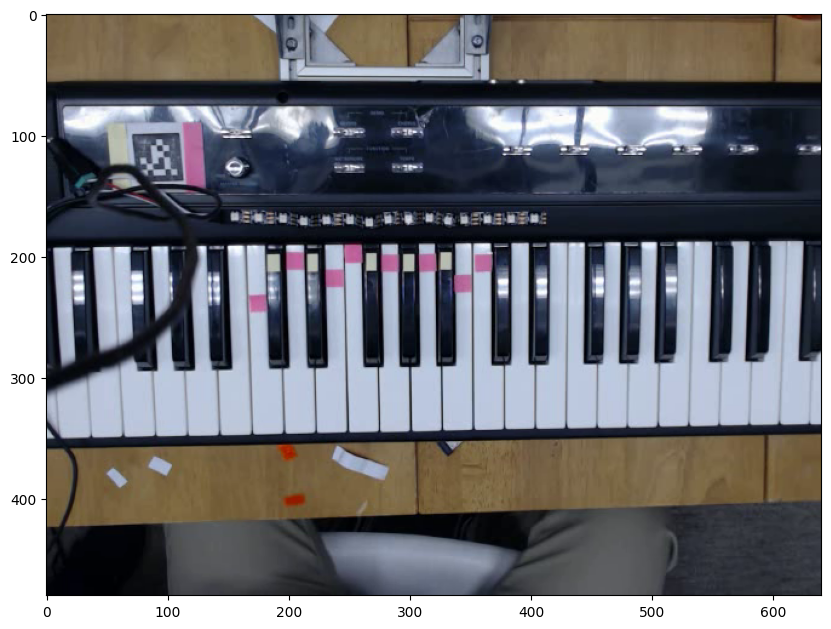

In [4]:
if ref_img_test is not None:
    ref_img_test = cv2.cvtColor(ref_img_test, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,10))
    plt.imshow(ref_img_test)
else:
    print("No reference image found")

In [5]:
ref_img_hsv = cv2.cvtColor(ref_img_test, cv2.COLOR_RGB2HSV)

## Color Picker code:

In [3]:
def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pixel = image[y, x]
        
        # Convert the BGR pixel into the HSV color space
        hsv = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        
        print("HSV Color: ", hsv)

# Load your image
image = ref_img_test
if image is None:
    print("Could not open or find the image.")
else:
    # Create a window
    cv2.namedWindow('image')
    
    # Set the mouse callback function to 'pick_color'
    cv2.setMouseCallback('image', pick_color)
    
    # Display the image
    cv2.imshow('image', image)
    
    # Wait until a key is pressed to exit
    cv2.waitKey(0)
    cv2.destroyAllWindows()

HSV Color:  [160 117 189]
HSV Color:  [160 117 189]
HSV Color:  [160 117 189]
HSV Color:  [160 117 189]
HSV Color:  [ 19  97 132]


## Clustering as Numpy Arrays

In [6]:
def apply_threshold_hsv(roi, hsv_color, threshold_h=10, threshold_s=35, threshold_v=80):
    """Apply color thresholding in HSV color space to isolate specific color ranges in the ROI."""
    
    lower_bound = np.array([max(0, hsv_color[0] - threshold_h), max(0, hsv_color[1] - threshold_s), max(0, hsv_color[2] - threshold_v)])
    upper_bound = np.array([min(180, hsv_color[0] + threshold_h), min(255, hsv_color[1] + threshold_s), min(255, hsv_color[2] + threshold_v)])
    mask = cv2.inRange(roi, lower_bound, upper_bound)
    return mask


def find_clusters(ref_img_hsv, hsv_color=(174, 131, 201), min_size_threshold=10, max_size_threshold=300):
    """
    Find clusters of points in an image based on a given HSV color.

    Parameters:
    - ref_img_hsv (numpy.ndarray): The input image in HSV color space.
    - hsv_color (tuple): The target HSV color to find clusters around. Default is (174, 131, 201).
    - min_size_threshold (int): The minimum size threshold for a cluster to be considered. Default is 10.
    - max_size_threshold (int): The maximum size threshold for a cluster to be considered. Default is 300.

    Returns:
    - numpy.ndarray: An array of filtered clusters, where each cluster is represented as an array of points.

    Note:
    - The input image should be in HSV color space.
    - The returned clusters are filtered based on their size, where the size is determined by the number of points in the cluster.
    """
    
    mask = apply_threshold_hsv(ref_img_hsv, hsv_color)
    
    y_coord, x_coord = np.where(mask != 0)
    if len(y_coord) == 0:
        return np.array([])  # Return an empty numpy array if no points found
    
    coord_array = np.stack((x_coord, y_coord), axis=-1)
    dbscan = DBSCAN(eps=5, min_samples=min_size_threshold)
    clusters = dbscan.fit_predict(coord_array)

    # Filter clusters based on size
    filtered_cluster_list = []
    for cluster_idx in np.unique(clusters):
        if cluster_idx != -1:
            cluster_points = coord_array[clusters == cluster_idx]
            if min_size_threshold <= len(cluster_points) <= max_size_threshold:
                filtered_cluster_list.append(cluster_points)
    return np.array(filtered_cluster_list, dtype=object)


def arrange_clusters(filtered_cluster_list):
    """
    Arrange clusters from left to right based on their mean x-coordinate.
    
    Parameters:
    - filtered_cluster_list: numpy.ndarray
        An array of filtered clusters, where each cluster is represented by an array of points.
        
    Returns:
    - numpy.ndarray
        An array of clusters sorted from left to right.
    """
    if len(filtered_cluster_list) == 0:
        return filtered_cluster_list  # Return the empty array if no clusters

    # Calculate the mean x-coordinate for each cluster
    mean_x_coords = [np.mean(cluster[:, 0]) for cluster in filtered_cluster_list]
    
    # Sort the clusters based on their mean x-coordinate
    sorted_indices = np.argsort(mean_x_coords)
    
    # Reorder the clusters based on the sorted indices
    sorted_clusters = filtered_cluster_list[sorted_indices]

    return sorted_clusters

### VISUALIZATION

8
168 233 14 13
198 198 14 13
231 212 15 14
246 191 15 15
277 200 13 12
308 200 14 12
337 216 13 14
354 200 14 12


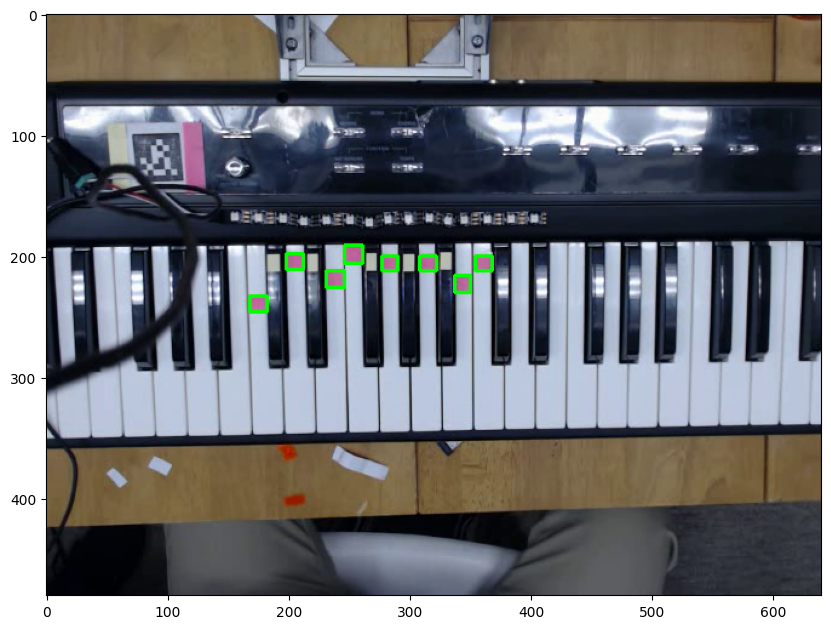

In [7]:
import matplotlib.patches as patches

def plot_clusters_on_image(clusters):
    """
    Plot an image and draw green bounding boxes with labels over the clusters.
    """
    tmp = ref_img_test.copy()
    
    for cluster in clusters:
        x, y, w, h = cv2.boundingRect(cluster)
        print(x, y, w, h)
        cv2.rectangle(tmp, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    plt.figure(figsize=(10,10))
    plt.imshow(tmp)
    plt.show()

# color = (174, 131, 201)
color = (160,117,189)
clusters = find_clusters(ref_img_hsv, hsv_color=color, min_size_threshold=50, max_size_threshold=200)
print(len(clusters))
clusters = arrange_clusters(clusters)
if len(clusters) > 0:
    plot_clusters_on_image(clusters)


## Centroid Calculation & Visualization

In [8]:
def calculate_centroids(filtered_cluster_list):
    """
    Calculate the centroids of filtered clusters.

    Parameters:
    - filtered_cluster_list: numpy.ndarray
        An array of filtered clusters, where each cluster is represented by an array of points.
        
    Returns:
    - list
        A list of centroids of the clusters.
    """
    centroids = []
    for cluster in filtered_cluster_list:
        centroid_x = np.mean(cluster[:, 0])
        centroid_y = np.mean(cluster[:, 1])
        centroids.append((centroid_x, centroid_y))
    return centroids


print(calculate_centroids(clusters))

[(174.39375, 239.1125), (204.5287356321839, 203.73563218390805), (237.67708333333334, 218.38541666666666), (252.95336787564767, 197.96891191709844), (283.0, 205.5), (314.2, 205.5), (343.1453488372093, 222.50581395348837), (360.69325153374234, 205.38036809815952)]


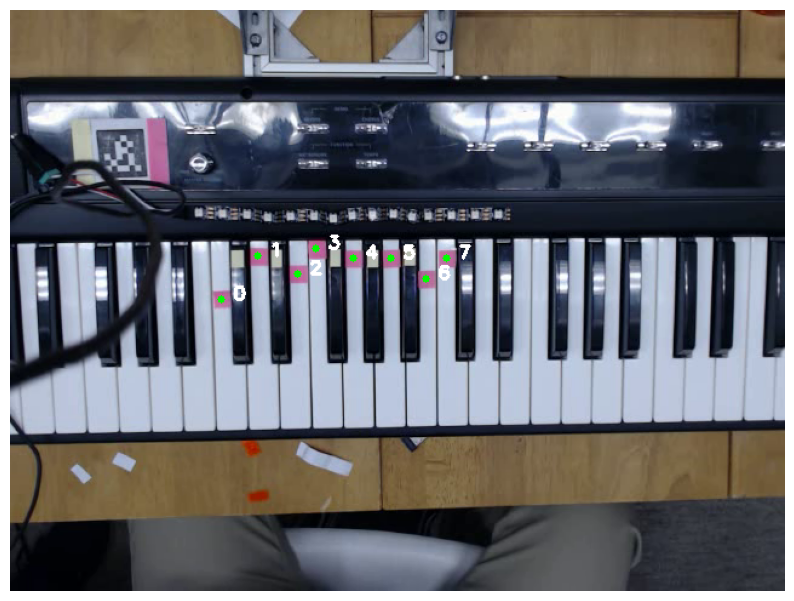

In [9]:
def plot_centroids_on_image(centroids, image):
    """
    Plot an image and draw a green dot at each centroid.
    
    Parameters:
    - centroids: list of tuples
        A list of coordinates representing the centroid of each cluster.
    - image: numpy.ndarray
        The image on which to plot the centroids.
    """
    tmp = image.copy()
    
    for idx, (cx, cy) in enumerate(centroids):
        # Draw a green dot at the centroid
        cv2.circle(tmp, (int(cx), int(cy)), 3, (0, 255, 0), -1)
        # Put the cluster index number next to the dot
        cv2.putText(tmp, str(idx), (int(cx) + 10, int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255, 255, 255), 2)
    
    plt.figure(figsize=(10,10))
    plt.imshow(tmp)
    plt.axis('off')  # Hide the axis
    plt.show()
    
plot_centroids_on_image(calculate_centroids(clusters), ref_img_test)

## Euclidean Distance Calculation & Testing

In [10]:
from scipy.spatial.distance import euclidean

def calculate_average_centroid_shift(ref_centroids, curr_centroids):
    """
    Calculate the average change in centroids caused by shaking.
    
    Parameters:
    - ref_centroids: list of tuples
        The reference centroids from the initial frame.
    - curr_centroids: list of tuples
        The centroids from the current frame.
        
    Returns:
    - float
        The average Euclidean distance between all corresponding centroid pairs.
    """
    if len(ref_centroids) != len(curr_centroids):
        raise ValueError("The number of centroids in both frames does not match.")
    
    # Calculate the Euclidean distances between each pair of corresponding centroids
    distances = [euclidean(ref_centroids[i], curr_centroids[i]) for i in range(len(ref_centroids))]
    
    # Calculate the average distance
    average_shift = np.mean(distances)
    
    return average_shift

In [ ]:
cap =  cv2.VideoCapture('cope.mp4')
ref_img_hsv = None
ref_centroids = None

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if ref_img_hsv is None:    
        ref_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        ref_clusters = find_clusters(ref_img_hsv, hsv_color=(174, 131, 201), min_size_threshold=50, max_size_threshold=200) 
        ref_clusters = arrange_clusters(ref_clusters)
        ref_centroids = calculate_centroids(ref_clusters)
    else:
        inference_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        inference_clusters = find_clusters(inference_img_hsv, hsv_color=(174, 131, 201), min_size_threshold=50, max_size_threshold=200)
        inference_clusters = arrange_clusters(inference_clusters)
        inference_centroids = calculate_centroids(inference_clusters)
        print(len(inference_centroids))
        if len(inference_centroids) == len(ref_centroids):
            average_shift = calculate_average_centroid_shift(ref_centroids, inference_centroids)
            print(average_shift)
    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

    cv2.waitKey(1)
    if cv2.getWindowProperty('Pressed Key Frame', cv2.WND_PROP_VISIBLE) < 1:
        break
    
cap.release()
cv2.destroyAllWindows()

## PCA & Visualization

In [21]:
import numpy as np
from sklearn.decomposition import PCA

def calculate_displacements(ref_centroids, curr_centroids):
    """
    Calculate displacements of centroids from the reference frame to the current frame.
    
    Parameters:
    - ref_centroids: list of tuples
        The reference centroids from the initial frame.
    - curr_centroids: list of tuples
        The centroids from the current frame.
        
    Returns:
    - numpy.ndarray
        The displacements of centroids.
    """
    # Ensure that both centroid lists have the same number of centroids
    if len(ref_centroids) != len(curr_centroids):
        raise ValueError("The number of centroids in both frames does not match.")

    # Calculate displacements as differences in x and y coordinates
    displacements = np.array(curr_centroids) - np.array(ref_centroids)
    return displacements

def perform_pca_on_displacements(displacements):
    """
    Perform PCA on centroid displacements to isolate camera shake vs key-presses.
    
    Parameters:
    - displacements: numpy.ndarray
        The displacements of centroids.
        
    Returns:
    - numpy.ndarray
        The transformed displacements in the space of principal components.
    """
    # Initialize PCA, assuming 2 components for 2D data
    pca = PCA(n_components=2)

    # Fit PCA to the displacement data
    pca.fit(displacements)

    # Transform the data
    transformed_data = pca.transform(displacements)
    return transformed_data

def identify_key_presses(transformed_displacements, threshold):
    """
    Identify if a key was pressed based on the displacement along the principal components.
    
    Parameters:
    - transformed_displacements: numpy.ndarray
        The centroids' displacements transformed into the principal component space.
    - threshold: float
        The threshold for identifying significant displacements indicating a key press.
        
    Returns:
    - List
        List of indices of centroids with a displacement above the threshold.
    """
    key_presses = []
    for i, displacement in enumerate(transformed_displacements):
        if np.abs(displacement[1]) > threshold:  # Change to the appropriate PC if necessary
            key_presses.append(i)
    
    return key_presses


In [23]:
# cap =  cv2.VideoCapture('output.mp4')
cap =  cv2.VideoCapture('cope.mp4')
# cap =  cv2.VideoCapture('output_no_press.mp4')
ref_img_hsv = None
ref_centroids = None

count = 0
CAPTURE_COUNT = 30
pca_threshold = 0.5
color = (160,117,189)
# color = (174, 131, 201)

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if ref_img_hsv is None and count == CAPTURE_COUNT:    
        ref_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        ref_clusters = find_clusters(ref_img_hsv, hsv_color=color, min_size_threshold=50, max_size_threshold=200) 
        ref_clusters = arrange_clusters(ref_clusters)
        ref_centroids = calculate_centroids(ref_clusters)
        print("Captured Reference Image")
    else:
        count += 1
    
    if ref_img_hsv is not None:
        inference_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        inference_clusters = find_clusters(inference_img_hsv, hsv_color=color, min_size_threshold=50, max_size_threshold=200)
        inference_clusters = arrange_clusters(inference_clusters)
        inference_centroids = calculate_centroids(inference_clusters)
        if len(inference_centroids) == len(ref_centroids):
            displacements = calculate_displacements(ref_centroids, inference_centroids)
            transformed_displacements = perform_pca_on_displacements(displacements)
            key_press_indices = identify_key_presses(transformed_displacements, threshold=pca_threshold)
            print('Key pressses: ', key_press_indices)

    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

    cv2.waitKey(1)
    if cv2.getWindowProperty('Pressed Key Frame', cv2.WND_PROP_VISIBLE) < 1:
        break
    
cap.release()
cv2.destroyAllWindows()


Captured Reference Image
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []


/Users/kaijun/opt/anaconda3/envs/ece180/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key pressses:  []
Key presss